## Correlation matrix

In [ ]:
from image_text_model.im_text_rnn_model import correlation_matrix

nb_batches = 781
checkpoint_dir = 'image_text_model/deep_sentiment_model'
posts_logits, posts_labels = correlation_matrix(nb_batches, checkpoint_dir)

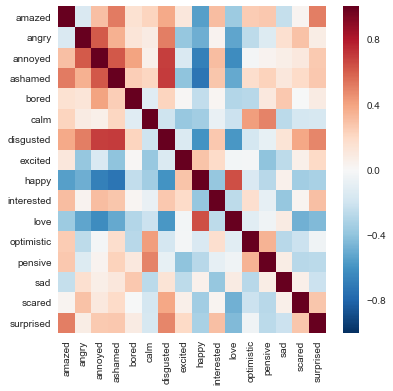

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datasets.dataset_utils import read_label_file
%matplotlib inline

posts_logits = np.load('data/posts_logits.npy')
labels_dict = read_label_file('data', 'photos')
corr_matrix = np.corrcoef(posts_logits, rowvar=False)

fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(corr_matrix, ax=ax)
graph_labels = [(int)(item.get_text()) for item in ax.get_xticklabels()]
ax.set_xticklabels(map(lambda x: labels_dict[x], graph_labels))
ax.set_yticklabels(map(lambda x: labels_dict[x], graph_labels[::-1]))
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.savefig('plots/correlation_matrix.png', dpi=300)
plt.show()

//anaconda/envs/tensorflow/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


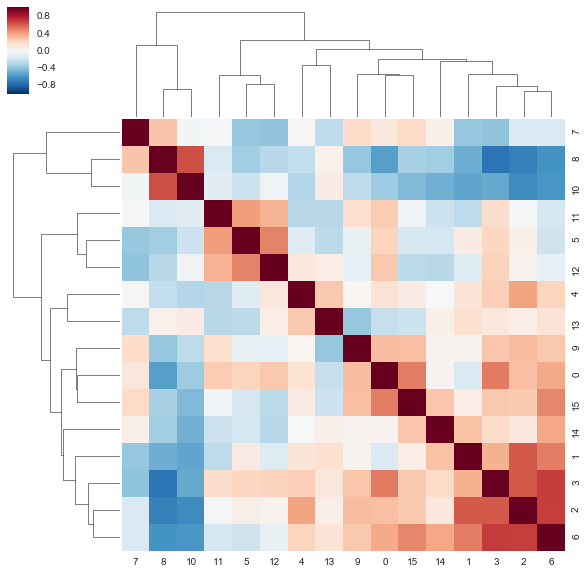

In [2]:
cg = sns.clustermap(corr_matrix)
#for i, ax in enumerate(cg.fig.axes):   # get all axes of the fig object
    #graph_labels = [(int)(item.get_text()) for item in ax.get_xticklabels()]
    #ax.set_xticklabels(map(lambda x: labels_dict[x], graph_labels), rotation=90)
    #ax.set_yticklabels(map(lambda x: labels_dict[x], graph_labels[::-1]), rotation=0)
plt.savefig('plots/dendogram2.png', dpi=300)
plt.show()

#import scipy.spatial as sp
#linkage1 = linkage(sp.distance.squareform(1 - corr_matrix, checks=False), method='average')
#sns.clustermap(1 - corr_matrix, row_linkage=linkage1, col_linkage=linkage1)

## PCA/MDS

In [52]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datasets.dataset_utils import read_label_file
%matplotlib inline

random_seed = 0
posts_logits = np.load('data/posts_logits.npy')
posts_labels = np.load('data/posts_labels.npy')
labels_dict = read_label_file('data', 'photos', filename='labels_all.txt')

np.random.seed(random_seed)
nb_samples = 4000
indices = np.random.choice(posts_logits.shape[0], nb_samples, replace=False)
posts_logits = posts_logits[indices]
posts_labels = posts_labels[indices]

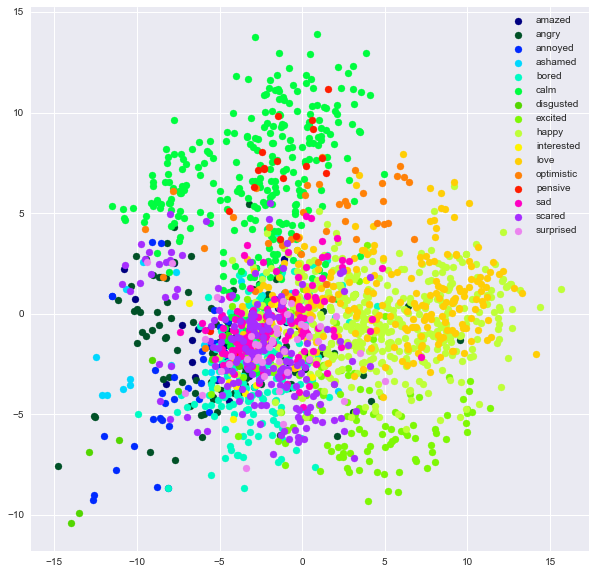

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_points = pca.fit_transform(posts_logits)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
for label in labels_dict.keys():
    mask = posts_labels == label
    ax.scatter(pca_points[mask, 0], pca_points[mask, 1], label=labels_dict[label])
colormap = plt.cm.gist_ncar#nipy_spectral, Set1,Paired  
colorst = [colormap(i) for i in np.linspace(0, 0.9, len(ax.collections))]       
for t, j1 in enumerate(ax.collections):
    j1.set_color(colorst[t])

ax.legend()
plt.show()

In [53]:
from sklearn.manifold import MDS

mds = MDS(random_state=9)
mds_points = mds.fit_transform(posts_logits)

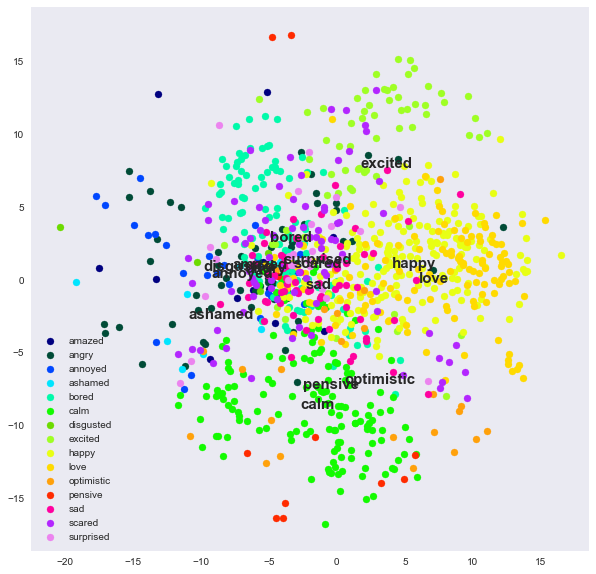

In [49]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
for label in labels_dict.keys():
    mask = posts_labels == label
    if labels_dict[label] != 'interested':
        ax.scatter(-mds_points[mask, 0], mds_points[mask, 1], label=labels_dict[label])
        ax.annotate(labels_dict[label], (-mds_points[mask, 0].mean() - 0.8, mds_points[mask, 1].mean() - 0.5), 
                    size=15, fontweight='bold')
colormap = plt.cm.gist_ncar 
colorst = [colormap(i) for i in np.linspace(0, 0.9, len(ax.collections))]       
for t, j1 in enumerate(ax.collections):
    j1.set_color(colorst[t])

ax.legend()
ax.grid(False)
plt.savefig('plots/mds.png', dpi=300)
plt.show()

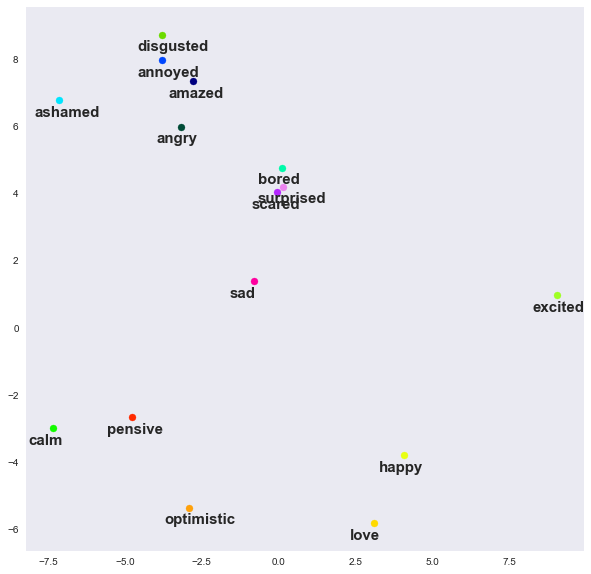

In [54]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
for label in labels_dict.keys():
    mask = posts_labels == label
    if labels_dict[label] != 'interested':
        ax.scatter(-mds_points[mask, 0].mean(), mds_points[mask, 1].mean(), label=labels_dict[label])
        ax.annotate(labels_dict[label], (-mds_points[mask, 0].mean() - 0.8, mds_points[mask, 1].mean() - 0.5), 
                    size=15, fontweight='bold')
colormap = plt.cm.gist_ncar 
colorst = [colormap(i) for i in np.linspace(0, 0.9, len(ax.collections))]       
for t, j1 in enumerate(ax.collections):
    j1.set_color(colorst[t])

#ax.legend()
ax.grid(False)
#plt.savefig('plots/mds-centers.png', dpi=300)
plt.show()

## Top words for each emotion

In [1]:
import os
import operator

import numpy as np
import pandas as pd
from text_model.text_preprocessing import _load_embedding_weights_glove, preprocess_one_df
from image_text_model.im_text_rnn_model import word_most_relevant
from datasets.dataset_utils import read_label_file

emotions = ['happy', 'sad', 'scared', 'angry', 'surprised', 'disgusted', 'annoyed', 'bored', 
'love', 'calm', 'amazed', 'optimistic', 'pensive', 'ashamed', 'excited'] #removed interested

df_dict = dict()

text_dir = 'text_model'
emb_dir = 'embedding_weights'
filename = 'glove.6B.50d.txt'
vocabulary, embedding = _load_embedding_weights_glove(text_dir, emb_dir, filename)
_POST_SIZE = 50
    
for emotion in emotions:
    df = preprocess_one_df(vocabulary, embedding, emotion, _POST_SIZE)
    df_dict[emotion] = df
    
columns = [u'id', u'post_url', u'type', u'timestamp',
           u'date', u'tags', u'liked', u'note_count',
           u'photo', u'text', u'search_query', u'text_list',
           u'text_len']
df_all = pd.DataFrame(columns = [])

for emotion in emotions:
    df_all = pd.concat([df_all, df_dict[emotion]]).reset_index(drop=True)

Finished loading word embedding weights.


In [2]:
# Get top 1000 most occurring words
vocabulary_count = dict(zip(vocabulary, np.zeros(len(vocabulary), dtype=np.int32)))
for i in range(df_all.shape[0]):
    for word in df_all['text'][i].lower().split():
        if word in vocabulary_count:
            vocabulary_count[word] += 1

In [5]:
nb_top_words = 1000
most_frequent_words = sorted(vocabulary_count.items(), key=operator.itemgetter(1), reverse=True)[:nb_top_words]

word_to_id = dict(zip(vocabulary, range(len(vocabulary))))
id_most_frequent_words = [word_to_id[x[0]] for x in most_frequent_words]

In [3]:
labels_dict = read_label_file('data', 'photos')
top_words = [41,
 4,
 0,
 5,
 7,
 81,
 3,
 192,
 6,
 12,
 14,
 20,
 285,
 10,
 100,
 34]
num_classes = 7#len(labels_dict)
checkpoint_dir = 'image_text_model/deep_sentiment_model'
scores, vocabulary, word_to_id = word_most_relevant(top_words, num_classes, checkpoint_dir)

Finished loading word embedding weights.


In [1]:
#######
## Analyse scores
######
import numpy as np
from text_model.text_preprocessing import _load_embedding_weights_glove
from datasets.dataset_utils import read_label_file

labels_dict = read_label_file('data', 'photos', filename='labels_all.txt')

text_dir = 'text_model'
emb_dir = 'embedding_weights'
filename = 'glove.6B.50d.txt'
vocabulary, embedding = _load_embedding_weights_glove(text_dir, emb_dir, filename)

word_to_id = dict(zip(vocabulary, range(len(vocabulary))))
id_to_word = {value:key for key, value in word_to_id.items()}
scores = np.load('data/top_words_scores.npy')
top_words = np.load('data/top_words.npy')

Finished loading word embedding weights.


In [9]:
labels_dict

{0: u'amazed',
 1: u'angry',
 2: u'annoyed',
 3: u'ashamed',
 4: u'bored',
 5: u'calm',
 6: u'disgusted',
 7: u'excited',
 8: u'happy',
 9: u'interested',
 10: u'love',
 11: u'optimistic',
 12: u'pensive',
 13: u'sad',
 14: u'scared',
 15: u'surprised'}

In [48]:
import numpy as np
import operator

emotion_index = 15
relevant_words_emotion = sorted(zip(range(scores.shape[0]), scores[:, emotion_index]), key=operator.itemgetter(1), reverse=True)[:40]
relevant_words_emotion = [x[0] for x in relevant_words_emotion]

In [49]:
print(labels_dict[emotion_index].title())
print(', '.join(map(lambda x: id_to_word[x], top_words[relevant_words_emotion])))

Surprised
surprised, tumblr, birthday, watched, upset, xd, cried, thank, yesterday, looked, allah, angry, told, sorry, heard, in., knew, gave, proud, said, telling, felt, facebook, amazing, oh, il, loved, yang, liked, sweet, friend, sa, seeing, *, worth, message, annoyed, negative, apparently, u


## DeepSentiment with fc layer

In [1]:
from image_text_model.im_text_rnn_model import train_deep_sentiment

checkpoints_dir = 'image_model/pretrained_model'
train_dir = 'image_text_model/deep_sentiment_model_2'
num_steps = 2
train_deep_sentiment(checkpoints_dir, train_dir, num_steps)

Finished loading word embedding weights.
Instructions for updating:
Use tf.losses.softmax_cross_entropy instead.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
Instructions for updating:
Use tf.losses.get_total_loss instead.
Instructions for updating:
Use tf.losses.get_losses instead.
Instructions for updating:
Use tf.losses.get_regularization_losses instead.
INFO:tensorflow:Starting Session.
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global_step/sec: 0
New learning rate: 0.001
INFO:tensorflow:global step 1: loss = 2.2918 (60.55 sec/step)
INFO:tensorflow:global step 2: loss = 2.3686 (33.10 sec/step)
INFO:tensorflow:Stopping Training.
INFO:tensorflow:Finished training! Saving model to disk.
Finished training. Last batch loss 2.369


In [ ]:
from image_text_model.im_text_rnn_model import evaluate_deep_sentiment

checkpoint_dir = 'image_text_model/deep_sentiment_model_2'
log_dir = 'image_text_model/model_eval_2'
mode = 'train'
num_evals = 2
evaluate_deep_sentiment(checkpoint_dir, log_dir, mode, num_evals)